In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')

### Randomly split a fileset into training, validation, and test sets: output lists of image names

In [2]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = './images/corel'
nclasses   = 6

# Set the desired image size for rescaling and maximum value for normalization

width       = 224 
height      = 224
nchannels   = 3
maxval      = 255. 
input_shape = (nchannels,height,width)

# Set the percentages of samples that will be used for training, validation and test. 

train_perc = 0.40
valid_perc = 0.30
test_perc  = 0.30

# Create training, validation, and test sets.

data = glob(orig_dir+"/*.png") # it returns a list of image filenames

num_train_samples = int(len(data)*train_perc)
num_valid_samples = int(len(data)*valid_perc)  
num_test_samples  = len(data) - num_train_samples - num_valid_samples 
np.random.shuffle(data) # randomly change the order of the filenames in data
trainset = data[:num_train_samples] 
validset = data[num_train_samples:num_train_samples+num_valid_samples]
testset  = data[num_train_samples+num_valid_samples:]

# Set output model name

model_name  = 'CorelCNN.pth'

### Create image datasets with some preprocessing: output a list of image tensors

In [3]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target) 

In [4]:
trainset = ImageDataset(trainset, aug) # verify the difference with and wothout data augmentation
validset = ImageDataset(validset, prep)
testset  = ImageDataset(testset, prep)

### Visualize selected images

Number of images: 142
Images are 224x224x3
Class of the image:  2


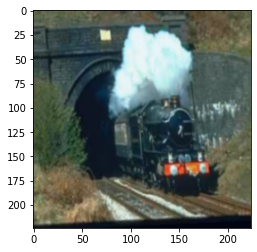

In [5]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[100] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

### Generate batches with batchsize images at random

In [6]:
batchsize = 32
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

inspect(next(iter(trainload))) # inspect a couple of items in the batches

list of 2 items
	Tensor	Shape: torch.Size([32, 3, 224, 224])	Min: -2.118	Max: 2.623	Mean: -0.470	dtype: torch.float32 @ cpu
	Tensor	Shape: torch.Size([32])	Min: 0.000	Max: 5.000	Mean: 2.219	dtype: torch.int64 @ cpu


### ConvNet model

In [7]:
# a convolutional block
def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        #defining convolutional layer 
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),
                  stride=1, padding=1, bias=False),
        #defining a batch normalization layer, which dismisses the need for bias in the previous conv layer
        nn.BatchNorm2d(num_features=nchannels_out),
        #defining activation layer
        nn.ReLU(),
        #defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

class CorelNet(nn.Module):

    def __init__(self, input_shape, num_classes):
        super(CorelNet, self).__init__()
        
        #defining feature extractor
        self.features = nn.Sequential(
            conv_block(input_shape[0],32,2),
            conv_block(32,256,2)
        )

        #defining classifier
        self.classifier = nn.Sequential(
            nn.Linear(in_features=input_shape[1]//4*input_shape[2]//4*256, out_features=64, bias=True),
            nn.ReLU(),
            nn.Dropout(0.20),
            nn.Linear(64, nclasses)
        )

        #initialize weights
        self._initialize_weights()

    def forward(self, x):
       #extracts features
        x = self.features(x)

        #transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        #classifies features
        y = self.classifier(x)
  
        return y
  
    def _initialize_weights(self):
        #for each submodule of our network
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels    
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=math.sqrt(2. / n))

                if m.bias is not None:
                    #initialize bias with 0 
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0 
                    m.bias.data.zero_()

### Create the model

In [8]:
model = CorelNet(input_shape, nclasses).to(device)
summary(model,input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 56, 56]         --
|    └─Sequential: 2-1                   [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 224, 224]        864
|    |    └─BatchNorm2d: 3-2             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-3                    [-1, 32, 224, 224]        --
|    |    └─MaxPool2d: 3-4               [-1, 32, 112, 112]        --
|    └─Sequential: 2-2                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-5                  [-1, 256, 112, 112]       73,728
|    |    └─BatchNorm2d: 3-6             [-1, 256, 112, 112]       512
|    |    └─ReLU: 3-7                    [-1, 256, 112, 112]       --
|    |    └─MaxPool2d: 3-8               [-1, 256, 56, 56]         --
├─Sequential: 1-2                        [-1, 6]                   --
|    └─Linear: 2-3                       [-1, 64]                  51,380,288
|

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 256, 56, 56]         --
|    └─Sequential: 2-1                   [-1, 32, 112, 112]        --
|    |    └─Conv2d: 3-1                  [-1, 32, 224, 224]        864
|    |    └─BatchNorm2d: 3-2             [-1, 32, 224, 224]        64
|    |    └─ReLU: 3-3                    [-1, 32, 224, 224]        --
|    |    └─MaxPool2d: 3-4               [-1, 32, 112, 112]        --
|    └─Sequential: 2-2                   [-1, 256, 56, 56]         --
|    |    └─Conv2d: 3-5                  [-1, 256, 112, 112]       73,728
|    |    └─BatchNorm2d: 3-6             [-1, 256, 112, 112]       512
|    |    └─ReLU: 3-7                    [-1, 256, 112, 112]       --
|    |    └─MaxPool2d: 3-8               [-1, 256, 56, 56]         --
├─Sequential: 1-2                        [-1, 6]                   --
|    └─Linear: 2-3                       [-1, 64]                  51,380,288
|

### Define the loss function with L2 regularization

In [9]:
def Criterion(model, preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long()) 
    # add l2_regularization            
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param,2)
    loss += 0.0001*l2_regularization # 0.0001 is the weight_decay
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data)
    n             = pred_labels.size(0)
    acc           = acc/n
    return loss, acc


criterion = Criterion

### Define optimizer and learning scheduler

In [10]:
optimizer    = optim.Adam(model.parameters(), lr=1e-5)
# gamma=0.1 is a multiplicative factor for lr decay at every epoch
# lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.1)
# gamma=0.1 is a multiplicative factor for lr decay at every step_size=number of epochs
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

### Clean up memory if needed

In [11]:
import gc
#del trainset, validset, testset
gc.collect()
torch.cuda.empty_cache()

### Define training and validation functions

In [12]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(model, preds, targets)
    return loss.item(), acc.item()

### Train the model and report the results

In [13]:
# initializing variables
n_epochs = 100
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%10==0: log.report_avgs(ex+1)
    #count epochs for auto-adjusting the learning rate
    lr_scheduler.step()

EPOCH: 10.000	trn_loss: 0.392	trn_acc: 0.887	val_loss: 0.493	val_acc: 0.827	(21.42s - 192.79s remaining)
EPOCH: 20.000	trn_loss: 0.249	trn_acc: 0.929	val_loss: 0.379	val_acc: 0.850	(42.73s - 170.92s remaining)
EPOCH: 30.000	trn_loss: 0.244	trn_acc: 0.954	val_loss: 0.287	val_acc: 0.891	(64.04s - 149.42s remaining)
EPOCH: 40.000	trn_loss: 0.213	trn_acc: 0.942	val_loss: 0.295	val_acc: 0.866	(85.44s - 128.16s remaining)
EPOCH: 50.000	trn_loss: 0.188	trn_acc: 0.961	val_loss: 0.308	val_acc: 0.891	(106.72s - 106.72s remaining)
EPOCH: 60.000	trn_loss: 0.163	trn_acc: 0.988	val_loss: 0.322	val_acc: 0.858	(128.03s - 85.35s remaining)
EPOCH: 70.000	trn_loss: 0.203	trn_acc: 0.944	val_loss: 0.299	val_acc: 0.858	(149.77s - 64.19s remaining)
EPOCH: 80.000	trn_loss: 0.213	trn_acc: 0.944	val_loss: 0.308	val_acc: 0.866	(170.83s - 42.71s remaining)
EPOCH: 90.000	trn_loss: 0.204	trn_acc: 0.954	val_loss: 0.312	val_acc: 0.873	(192.06s - 21.34s remaining)
EPOCH: 100.000	trn_loss: 0.164	trn_acc: 0.950	val_loss

### Plot the results

100%|██████████████████████████████████████| 201/201 [00:00<00:00, 11097.21it/s]


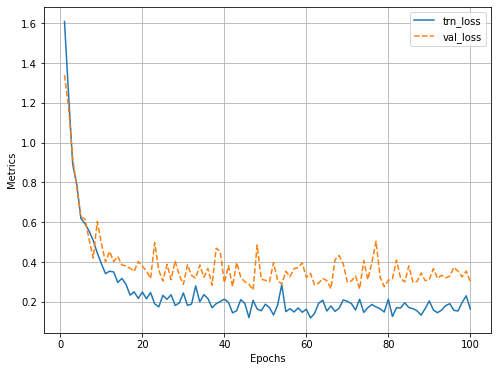

100%|██████████████████████████████████████| 201/201 [00:00<00:00, 10461.69it/s]


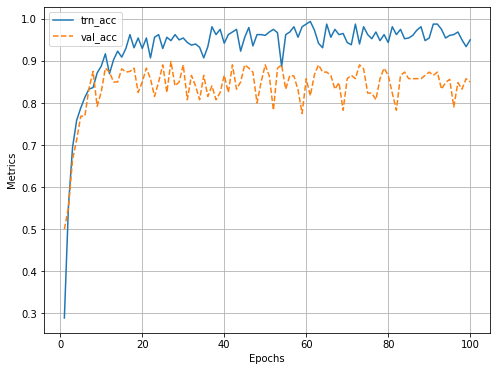

In [14]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])

### Evaluate the model

In [15]:
def Test(model, testload, criterion, device):
    N = len(testload)
    mean_loss = 0
    mean_acc  = 0
    for bx, data in enumerate(testload):
        loss, acc  = validate_batch(model, data, criterion, device)
        mean_loss += loss
        mean_acc  += acc
    
    mean_loss = mean_loss / N
    mean_acc  = mean_acc / N
    return(mean_loss, mean_acc)

(loss, acc) = Test(model, testload, criterion, device)
print('Loss: {:.6f} Acc: {:.6f}'.format(loss,acc))

Loss: 0.287021 Acc: 0.907670


### Save the model

In [16]:
torch.save(model.to('cpu').state_dict(), model_name)

#### Exercise: Play with optimizers, network architecture and hyperparameters to improve results without underfitting and overfitting. Note that you are using data augmentation, which might requires more epochs and lower learning rates for convergence. Verify preprocessing with no data augmentation and less training samples with data augmentation. 